In [1]:
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from brian2.only import *

%load_ext autoreload
%autoreload 1

%aimport numpy_
%aimport spatial
%aimport model
%aimport inputs
%aimport util
%aimport spike_utils

# for the IDE:
import numpy_ as np
import spatial, model, inputs

from util import concatenate
np.concatenate = concatenate
from spike_utils import iterspikes

In [2]:
rng = np.random.default_rng()
set_device('cpp_standalone')
prefs.devices.cpp_standalone.openmp_threads = mp.cpu_count() - 2

In [3]:
N = 1000
inhibitory_ratio = .2

params = {
    # Simulation
    'dt': 1*ms,
    
    # Population size
    'N': N,
    'N_exc': int((1-inhibitory_ratio) * N),
    'N_inh': int(inhibitory_ratio * N),

    # Membrane
    'v_rest': -60*mV,
    'v_reset': -74*mV,
    'v_threshold': -54*mV,
    'voltage_init': 'v_rest',
    
    'tau_mem': 30*ms,
    'refractory_exc': 3*ms,
    'refractory_inh': 2*ms,

    # Threshold adaptation - Exc
    'th_tau': 1*second,
    'th_ampl': 1*mV,

    # Short-term plasticity - Exc
    'tau_rec': 150*msecond,
    'U': 0.4,

    # Synapse dynamics
    'E_exc': 0*mV,
    'tau_ampa': 2*msecond,
    'E_inh': -100*mV,
    'tau_gaba': 4*msecond,
    
    # # Stochasticity
    # 'tau_noise': 10*msecond,
    # 'vnoise_std': 0.5*mV,

    # Layout
    'r_dish': 4*mm,
    
    # Connectivity: Inh
    'r_inh': 1*mm,
    'outdeg_inh': 50,
    'w_inh_mean': np.log(1),
    'w_inh_sigma': 0.2,

    # Connectivity: Exc
    'r_exc': 2*mm,
    'outdeg_exc': 30,
    'w_exc_mean': np.log(1.5),
    'w_exc_sigma': 0.2,

    # Stimulus
    'N_stimuli': 5,
    'stim_distribution_radius': 2.5*mm,
    'neurons_per_stim': 10,
    'input_strength': 100,

    # Paradigm
    'settling_period': 1*second,
    'sequence_length': 5,
    'sequence_count': 20,
    'fully_random_msc': True,
    'ISI': 500*ms,
}

In [4]:
def get_episode_spikes(Net, params, episode=0, sorted=True):
    offset = 0
    T, I = [], []
    episode_duration = params['ISI']*params['sequence_length']*params['sequence_count']
    full_episode_duration = params['settling_period'] + episode_duration
    t0 = episode * full_episode_duration + params['settling_period']
    for k in ['Exc', 'Inh']:
        t, i = Net[f'SpikeMon_{k}'].t, Net[f'SpikeMon_{k}'].i + offset
        offset += Net[k].N
        mask = (t > t0) & (t < t0 + episode_duration)
        T.append(t[mask])
        I.append(i[mask])
    T = np.concatenate(T) - t0
    I = np.concatenate(I)
    if sorted:
        sorted = np.argsort(T)
        T, I = T[sorted], I[sorted]
    return I, T

In [5]:
def get_neuron_spike_counts(N, pulsed_i, sequence, target_item):
    numspikes = np.zeros(N, dtype=int)
    for pulse_idx, pulse_item in enumerate(sequence):
        if pulse_item == target_item:
            np.add.at(numspikes, pulsed_i[pulse_idx], 1)
    return numspikes

In [6]:
def get_pulse_spike_counts_TMP(t, ISI):
    pulse_number = t // ISI
    steps = np.flatnonzero(np.diff(pulse_number) > 0)
    internal_num_spikes = np.diff(steps)
    num_spikes = np.concatenate([[steps[0]+1], internal_num_spikes, [0]])
    num_spikes[-1] = len(t) - np.sum(num_spikes)
    return num_spikes

In [7]:
def get_pulse_spike_counts(Net, params, episode=0):
    I, T = get_episode_spikes(Net, params, episode=episode)
    return get_pulse_spike_counts_TMP(T, params['ISI'])

In [8]:
def populate_spike_results(Net, params, results, episode=0):
    results['nspikes'] = get_pulse_spike_counts(Net, params, episode)
    results['spike_i'], results['spike_t'] = get_episode_spikes(Net, params, episode=episode)
    results['pulsed_i'], results['pulsed_t'] = zip(*list(iterspikes(
        results['spike_i'], results['spike_t'],
        params['sequence_length']*params['sequence_count'], params['ISI'])))
    results['pulsed_nspikes'] = np.zeros((len(results['pulsed_i']), params['N']), int)
    for j, i in enumerate(results['pulsed_i']):
        np.add.at(results['pulsed_nspikes'][j], i, 1)

In [9]:
def get_stimulus_results(Std, Msc, Dev, target, params):
    npulses = np.array([np.sum(Std['Seq']==target), np.sum(Msc['Seq']==target), np.sum(Dev['Seq']==target)])
    spikes = np.zeros((3, params['N']))
    spikes[0] = get_neuron_spike_counts(params['N'], Std['pulsed_i'], Std['Seq'], target)
    spikes[1] = get_neuron_spike_counts(params['N'], Msc['pulsed_i'], Msc['Seq'], target)
    spikes[2] = get_neuron_spike_counts(params['N'], Dev['pulsed_i'], Dev['Seq'], target)
    spikes_per_target = spikes / npulses[:, None]
    return spikes, spikes_per_target, npulses

In [10]:
def get_overlaps(params, Astd, Bstd, MSC, A, B, Cx):
    posthoc_class = {}
    any_active = np.zeros((3, params['N']), bool)
    for i, identity in enumerate(([A], [B], Cx)):
        # Mark neurons that are active in response to <identity> in any paradigm:
        for results in (Astd, Bstd, MSC):
            any_active[i] |= np.any(results['pulsed_nspikes'][np.isin(results['Seq'], identity)], axis=0)
    for a in [True, False]:
        for b in [True, False]:
            for cx in [True, False]:
                target = np.asarray([a, b, cx])
                value = np.all(any_active == target[:, None], axis=0)
                key = ''.join([char for char, present in zip(['A','B','Cx'], [a,b,cx]) if present])
                posthoc_class[key] = np.flatnonzero(value)
    return posthoc_class

In [11]:
networks, stims, results = [], [], []
classifications, spikes_per = [], []
sufficiency = []
for i in range(100):
    X, Y, W, D = spatial.create_weights(params, rng)
    Xstim, Ystim = spatial.create_stimulus_locations(params)
    A, B = params['N_stimuli']-1, rng.choice(params['N_stimuli']-1)
    Cx = np.arange(params['N_stimuli'])
    Cx[A] = Cx[B] = -1
    Cx = Cx[Cx>=0]

    Astd, Bstd, MSC = {}, {}, {}

    device.reinit()
    device.activate()
    Net = model.create_network(X, Y, Xstim, Ystim, W, D, params)
    Astd['Seq'], T = inputs.create_oddball(Net, params, A, B)
    Bstd['Seq'], T = inputs.create_oddball(Net, params, B, A, offset=T)
    MSC['Seq'], T = inputs.create_MSC(Net, params, rng, offset=T)
    Net.run(T)

    populate_spike_results(Net, params, Astd, 0)
    populate_spike_results(Net, params, Bstd, 1)
    populate_spike_results(Net, params, MSC, 2)

    classified_neurons = get_overlaps(params, Astd, Bstd, MSC, A, B, Cx)
    classifications.append(classified_neurons)

    networks.append((X, Y, W, D))
    stims.append((A, B))
    results.append((Astd, Bstd, MSC))

    spikes_A, spikes_per_A, npulses_A = get_stimulus_results(Astd, MSC, Bstd, A, params)
    spikes_B, spikes_per_B, npulses_B = get_stimulus_results(Bstd, MSC, Astd, B, params)
    nspikes_per_A, nspikes_per_B = spikes_per_A.sum(1), spikes_per_B.sum(1)
    spikes_per.append(np.concatenate([nspikes_per_A, nspikes_per_B]))

    overlap_size = {key: len(value) for key, value in classified_neurons.items()}
    overlap_ab = {k:v for k,v in overlap_size.items() if k in ('A','B','AB')}
    sufficient_overlap = all([v > 10 for v in overlap_ab.values()])

    sufficient_DD_A = (nspikes_per_A[2] > 1.2*nspikes_per_A[1]) and (nspikes_per_A[2] > 1.2*nspikes_per_A[0])
    sufficient_DD_B = (nspikes_per_B[2] > 1.2*nspikes_per_B[1]) and (nspikes_per_B[2] > 1.2*nspikes_per_B[0])
    
    sufficient = sufficient_overlap and sufficient_DD_A and sufficient_DD_B
    sufficiency.append(sufficient)

    print(i, sufficient, overlap_ab, sufficient_overlap, nspikes_per_A, sufficient_DD_A, nspikes_per_B, sufficient_DD_B)

WARNING    OpenMP code is not yet well tested, and may be inaccurate. [brian2.devices.cpp_standalone.device.openmp]


0 False {'AB': 2, 'A': 9, 'B': 5} False [118.4875  72.7    323.55  ] True [115.65        89.23809524 117.35      ] False
1 False {'AB': 26, 'A': 7, 'B': 8} False [298.8375     448.80769231 498.6       ] False [273.4625     524.33333333 648.15      ] True
2 False {'AB': 0, 'A': 1, 'B': 27} False [32.175 38.125 38.8  ] False [307.7625 381.75   632.95  ] True
3 False {'AB': 32, 'A': 8, 'B': 25} False [150.425      109.84210526 150.9       ] False [341.1    479.6875 611.    ] True
4 False {'AB': 43, 'A': 21, 'B': 13} True [361.05  531.875 538.75 ] False [187.9125     288.31818182 322.8       ] False
5 False {'AB': 19, 'A': 5, 'B': 11} False [296.825      369.66666667 546.25      ] True [ 89.725 177.6   202.8  ] False
6 False {'AB': 50, 'A': 32, 'B': 19} True [209.375      284.94444444 442.45      ] True [198.075 481.8   454.7  ] False
7 False {'AB': 24, 'A': 9, 'B': 14} False [263.6875     311.88235294 392.        ] True [210.         188.55555556 233.45      ] False
8 False {'AB': 11, 'A'

66 False {'AB': 193, 'A': 25, 'B': 66} True [195.2        390.61904762 345.05      ] False [274.0875     518.66666667 469.8       ] False
67 False {'AB': 7, 'A': 3, 'B': 15} False [115.575      153.52380952 216.45      ] True [214.2125 173.     627.    ] True
68 False {'AB': 2, 'A': 12, 'B': 1} False [418.8        588.35714286 674.9       ] False [127.1875      72.80952381  84.45      ] False
69 True {'AB': 85, 'A': 14, 'B': 24} True [166.025      121.76190476 438.8       ] True [133.7        299.89473684 449.9       ] True
70 False {'AB': 87, 'A': 30, 'B': 16} True [141.925      243.64285714 340.05      ] True [115.6  126.65 148.35] False
71 False {'AB': 14, 'A': 19, 'B': 8} False [290.175     338.0952381 690.9      ] True [ 57.35       143.82608696 152.6       ] False
72 False {'AB': 16, 'A': 3, 'B': 6} False [145.9375     331.57142857 608.3       ] True [179.025      152.91304348 632.65      ] True
73 False {'AB': 22, 'A': 7, 'B': 19} False [ 80.625      199.76470588  60.7       ] F

In [12]:
spikes_per = np.asarray(spikes_per).T

Text(0.5, 0, 'dev - msc (23/100 < 0, mean 0.44, med 0.25)')

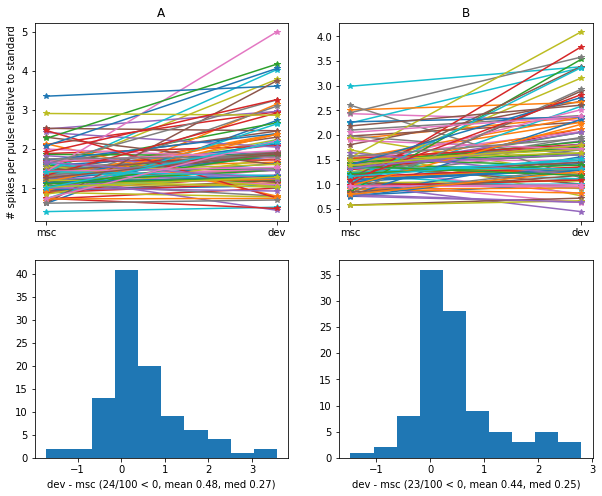

In [17]:
fig, axs = plt.subplots(2,2,figsize=(10,8))

axs[0, 0].plot(spikes_per[1:3] / spikes_per[0], '-*')
axs[0, 0].set_title('A')
axs[0, 0].set_ylabel('# spikes per pulse relative to standard')
axs[0, 0].set_xticks([0,1], ['msc', 'dev'])

axs[0, 1].plot(spikes_per[4:6] / spikes_per[3], '-*')
axs[0, 1].set_title('B')
axs[0, 1].set_xticks([0,1], ['msc', 'dev'])

s = (spikes_per[2] - spikes_per[1])/spikes_per[0]
axs[1, 0].hist(s)
axs[1, 0].set_xlabel(f'dev - msc ({(s<0).sum()}/{spikes_per.shape[1]} < 0, mean {s.mean():.2f}, med {np.median(s):.2f})')

s = (spikes_per[5] - spikes_per[4])/spikes_per[3]
axs[1, 1].hist(s)
axs[1, 1].set_xlabel(f'dev - msc ({(s<0).sum()}/{spikes_per.shape[1]} < 0, mean {s.mean():.2f}, med {np.median(s):.2f})')

In [18]:
np.sum(sufficiency)

4